This link contains information on CCREPE:
    
    https://www.bioconductor.org/packages/devel/bioc/vignettes/ccrepe/inst/doc/ccrepe.pdf

In [3]:
%matplotlib inline
%load_ext rmagic

from __future__ import division

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from biom import load_table
from scipy.stats import mannwhitneyu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

/Users/yoshikivazquezbaeza/.virtualenvs/qiime-191/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


# Dysbiosis index at level 6

We filter the table for low abundnce OTUs to only consider well represented features.

In [141]:
!summarize_taxa.py -i otu_table.15000.25percent.biom -o stats/group-significance/taxa-summaries-25pct

In [142]:
%%R

library("ccrepe")

otus <- read.table("stats/group-significance/taxa-summaries-25pct/otu_table.15000.25percent_L6.txt",
                   sep="\t", header=TRUE, skip=1, comment.char='')
rownames(otus) <- otus$X.OTU.ID
otus$X.OTU.ID <- NULL

otus.score <- ccrepe(x=t(otus), iterations=1000, sim.score=nc.score)

write.table(otus.score$sim.score,
            file='stats/group-significance/no-diarrhea/ccrepe/ccrepe-sim-score-otu_table.filtered.25pct_L6.txt',
            quote=FALSE, sep='\t')

write.table(otus.score$z.stat,
            file='stats/group-significance/no-diarrhea/ccrepe/ccrepe-z-stat-otu_table.filtered.25pct_L6.txt',
            quote=FALSE, sep='\t')

write.table(otus.score$p.values,
            file='stats/group-significance/no-diarrhea/ccrepe/ccrepe-p-values-otu_table.filtered.25pct_L6.txt',
            quote=FALSE, sep='\t')

write.table(otus.score$q.values,
            file='stats/group-significance/no-diarrhea/ccrepe/ccrepe-q-values-otu_table.filtered.25pct_L6.txt',
            quote=FALSE, sep='\t')

# Visualize these relationships as a heatmap

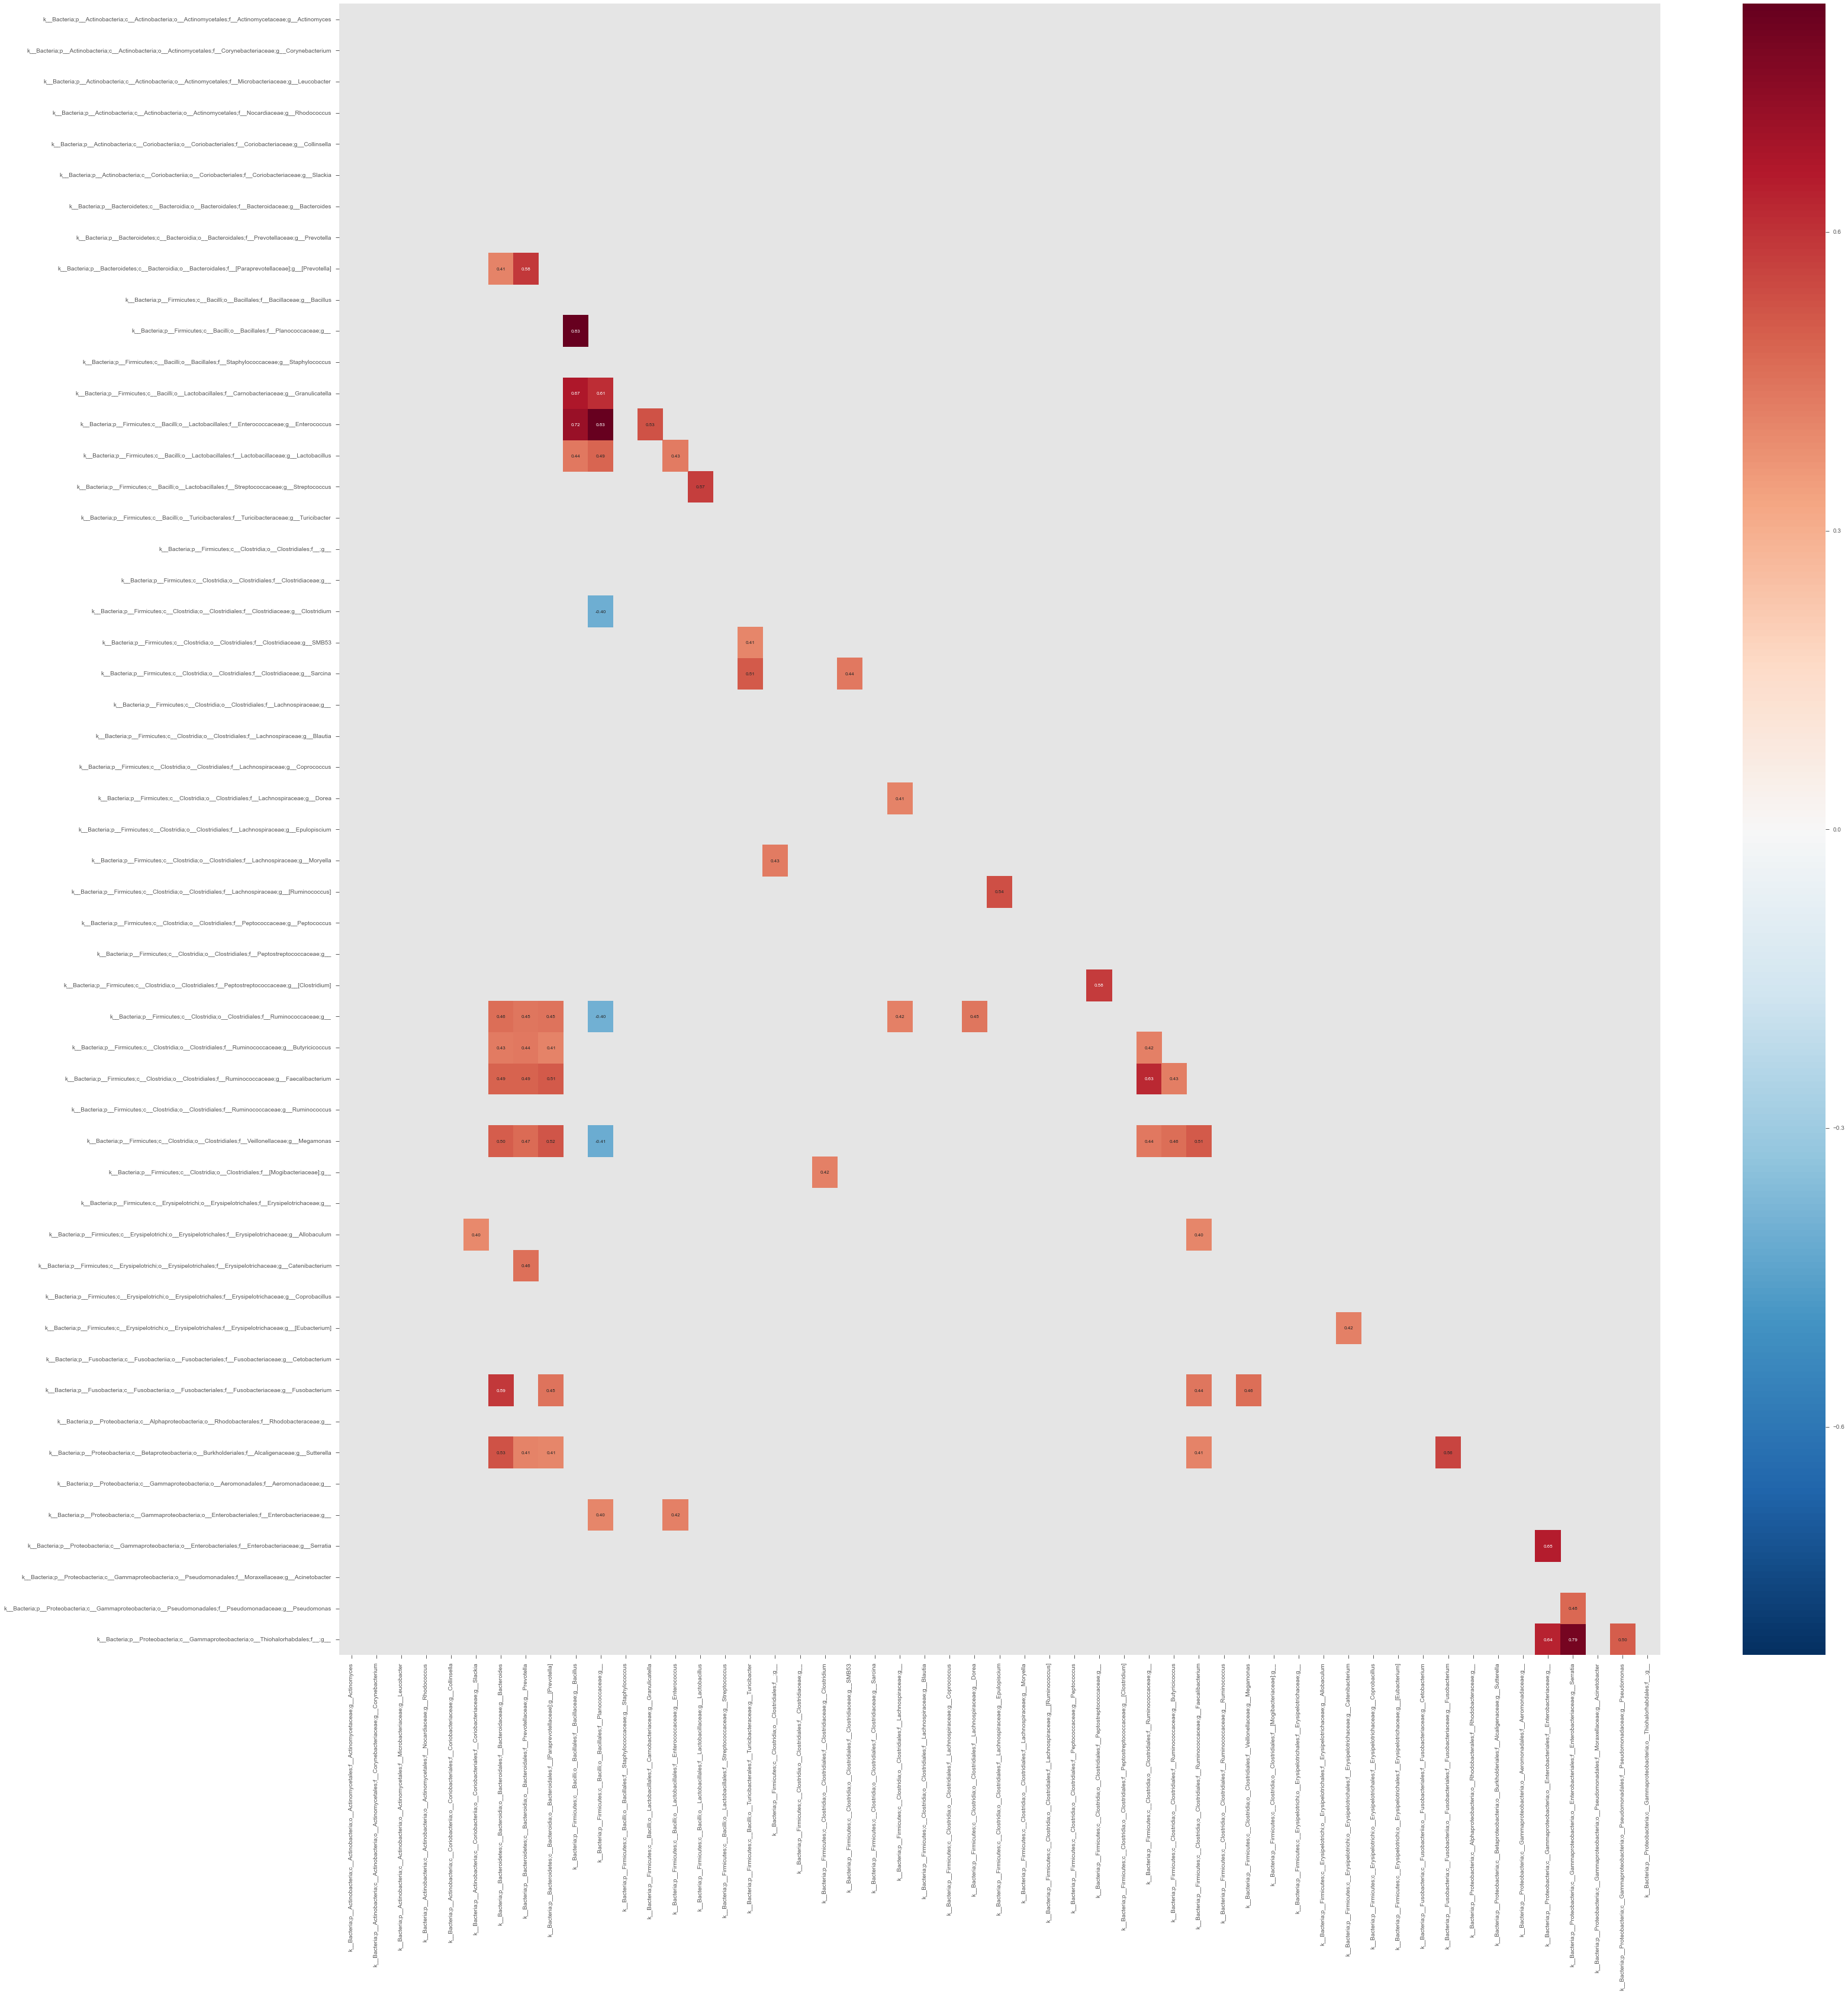

In [143]:
otus_score = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-sim-score-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
z_stats = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-z-stat-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
p_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-p-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
q_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-q-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')

mask = np.zeros_like(otus_score, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# filter by the threshold
T = 0.4
mask = mask | ((otus_score < T) & (otus_score > (T*-1)))

# set a true value for all things that are not positive/negative
# in both matrices
es_filter_pos = (otus_score < 0) & (z_stats < 0)
es_filter_neg = (otus_score > 0) & (z_stats > 0)

# with the two matrices just remove whatever both matrices agreed
# on and save the data inside mask, we also want to use the pvalues
mask |= (es_filter_pos & es_filter_neg & (q_values > 0.05))

plt.figure(figsize=(50, 50))

g = sns.heatmap(otus_score, mask=mask, annot=True, fmt=".2f",
            annot_kws={'fontdict': {'fontsize': 8}})

plt.savefig('stats/group-significance/no-diarrhea/ccrepe/ccrepe-otu_table.filtered.25pct_L6.pdf')

In [144]:
!group_significance.py -i stats/group-significance/taxa-summaries-25pct/otu_table.15000.25percent_L6.biom \
-o stats/group-significance/taxa-summaries-25pct/kruskall-wallis.txt \
-m mapping-file-full.txt \
--category disease_stat

# Visualize the data as a network

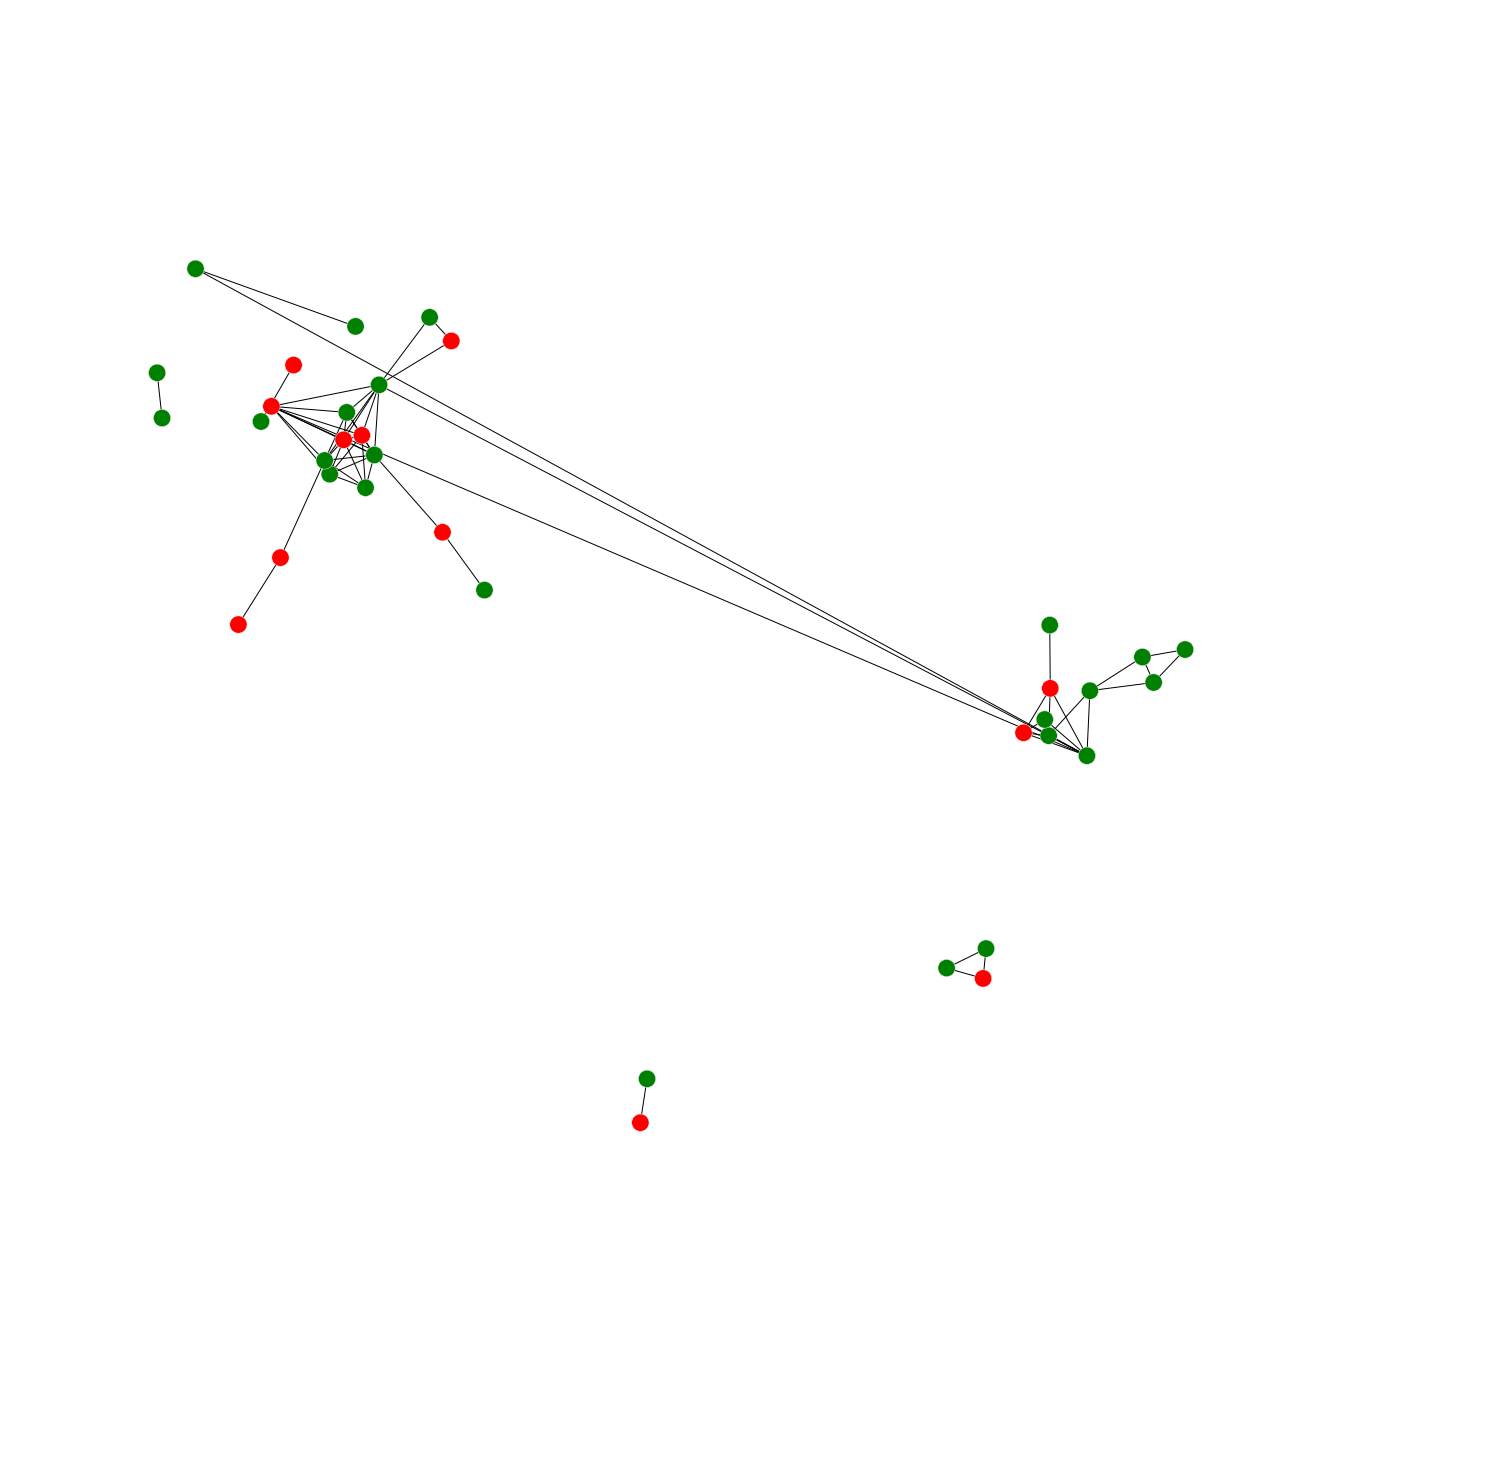

In [48]:
import networkx as nx

otus_score = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-sim-score-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
z_stats = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-z-stat-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
p_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-p-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
q_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-q-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')

mask = np.zeros_like(otus_score, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# filter by the threshold
T = 0.4
mask = mask | ((otus_score < T) & (otus_score > (T*-1)))

# set a true value for all things that are not positive/negative
# in both matrices
es_filter_pos = (otus_score < 0) & (z_stats < 0)
es_filter_neg = (otus_score > 0) & (z_stats > 0)

# with the two matrices just remove whatever both matrices agreed
# on and save the data inside mask, we also want to use the pvalues
mask |= (es_filter_pos & es_filter_neg & (q_values > 0.05))

kw_stats = pd.read_csv('stats/group-significance/taxa-summaries-25pct/kruskall-wallis.txt', sep='\t', index_col='OTU')
def color_funk(row):
    if row['healthy_mean'] > row['IBD_mean']:
        return 'g'
    else:
        return 'r'
colors = kw_stats.apply(color_funk, axis=1, reduce=False)

plt.figure(figsize=(20, 20))
G = nx.from_numpy_matrix(~mask.values)
G = nx.relabel_nodes(G, {i: o for i, o in enumerate(mask.index.tolist())})
G.remove_nodes_from([n for n in G.nodes_iter() if len(G.edges(n)) == 0])

for e in G.edges_iter():
    u, v = e
    weight = otus_score.loc[u][v]
    if weight > 0 :
        relation = 'coccurrence'
    else:
        relation = 'coexlcusion'

    G.add_edge(u, v, weight=weight, relation=relation)

nx.spring_layout(G)

#nx.draw(G, node_list=colors.index.tolist(), node_color=colors.tolist(), node_name=kw_stats.index.tolist())
nx.draw(G, node_list=colors.index.tolist(), node_color=colors.tolist())

## Create these files to make importing in Cytoscape easier

In [72]:
node_attrs = pd.DataFrame()

kw_stats = pd.read_csv('stats/group-significance/taxa-summaries-25pct/kruskall-wallis.txt', sep='\t', index_col='OTU')
def color_funk(row):
    if row['healthy_mean'] > row['IBD_mean']:
        return 'protective'
    else:
        return 'inflammatory'
node_attrs['role'] = kw_stats.apply(color_funk, axis=1, reduce=False)

def short_name(row):
    #f__Planococcaceae;g__
    n = row.name.split('f__')[1]
    n = n.replace(';g__', ' ')
    
    if n.strip() == '':
        n = row.name.split('o__')[1].split(';')[0]
    return n
node_attrs['short_name'] = kw_stats.apply(short_name, axis=1, reduce=False)

In [73]:
node_attrs.to_csv('node-attributes.txt')

In [49]:
nx.write_edgelist(G, 'test.edgelist.2.txt', data=True)

# Largest connected component only

From the inferred network, filter to preserve only the largest connected component of the graph.

In [6]:
import networkx as nx
import igraph

otus_score = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-sim-score-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
z_stats = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-z-stat-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
p_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-p-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
q_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-q-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')

mask = np.zeros_like(otus_score, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# filter by the threshold
T = 0.4
mask = mask | ((otus_score < T) & (otus_score > (T*-1)))

# set a true value for all things that are not positive/negative
# in both matrices
es_filter_pos = (otus_score < 0) & (z_stats < 0)
es_filter_neg = (otus_score > 0) & (z_stats > 0)

# with the two matrices just remove whatever both matrices agreed
# on and save the data inside mask, we also want to use the pvalues
mask |= (es_filter_pos & es_filter_neg & (q_values > 0.05))


kw_stats = pd.read_csv('stats/group-significance/taxa-summaries-25pct/kruskall-wallis.txt', sep='\t', index_col='OTU')
def color_funk(row):
    if row['healthy_mean'] > row['IBD_mean']:
        return 0x00ff00
    else:
        return 0xff0000
colors = kw_stats.apply(color_funk, axis=1, reduce=False)

# XXXXXX
connected_components = list(nx.connected_component_subgraphs(G))
largest_cc = max(connected_components, key=len)

nodes = {i: {'color': colors[i], 'size':1.25} for i in largest_cc.nodes_iter()}

edges = []
for edge in largest_cc.edges_iter():
    val = otus_score[edge[0]][edge[1]]
    if val > 0:
        edges.append({'source': edge[0], 'target': edge[1], 'color': 0x800080})
    elif val < 0:
        edges.append({'source': edge[0], 'target': edge[1], 'color': 0xFF8000})

graph = {
    'nodes': nodes,
    'edges': edges
}
igraph.draw(graph, directed=False)

# Dysbiosis Index

To define the dysbiosis index, we first need to have calculated the nc-score tables with `CCREPE`, along with the z-stats and corrected p-values, once we've done this, the general steps we need to follow are:

* Remove useless and redundant data:
    * Remove the upper diagonal of the matrix.
    * Remove nc-scores that differ in sign with the z statistics.
    * Remove nc-scores that have a q value above 0.05.
    * Filter all nc-scores at a threshold so as to keep only the **strong** associations.
* Build a weighted graph from the resulting matrix:
    * Find the largest connected component and only keep these vertices.
* Separate the nodes of the graph by the OTUs that had a higher mean in `healthy` samples than in `ibd` samples.
    * We create two sets of OTUs $I$ and $H$, such that $\forall i \in I$ the abundance of every OTU $i$ was higher in the samples with IBD than in the healthy samples, conversely $\forall h \in H$ the abundance of every OTU $h$ was higher in samples of healthy dogs than in the samples of dogs with IBD.
* Finally, for every sample, we define the microbial dysbiosis index (similarly to how it was done in Gevers et al) value as:

$md \left(sample \right) = Log \left(\frac{ \sum_{i \in I} sample[i] }{ \sum_{h \in H} sample[h] } \right)$

### Summarize everythign as a single cell to create the appropriate columns

In [19]:
import networkx as nx
import igraph

otus_score = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-sim-score-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
z_stats = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-z-stat-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
p_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-p-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')
q_values = pd.read_csv('stats/group-significance/no-diarrhea/ccrepe/ccrepe-q-values-otu_table.filtered.25pct_L6.txt',
                         sep='\t')

mask = np.zeros_like(otus_score, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# filter by the threshold
T = 0.4
mask = mask | ((otus_score < T) & (otus_score > (T*-1)))

# set a true value for all things that are not positive/negative
# in both matrices
es_filter_pos = (otus_score < 0) & (z_stats < 0)
es_filter_neg = (otus_score > 0) & (z_stats > 0)

# with the two matrices just remove whatever both matrices agreed
# on and save the data inside mask, we also want to use the pvalues
mask |= (es_filter_pos & es_filter_neg & (q_values > 0.05))

kw_stats = pd.read_csv('stats/group-significance/taxa-summaries-25pct/kruskall-wallis.txt',
                       sep='\t', index_col='OTU')

G = nx.from_numpy_matrix(~mask.values, parallel_edges=False, create_using=nx.Graph())
G = nx.relabel_nodes(G, {i: o for i, o in enumerate(mask.index.tolist())})
G.remove_nodes_from([n for n in G.nodes_iter() if len(G.edges(n)) == 0])

# find the largest connected component
connected_components = list(nx.connected_component_subgraphs(G))
largest_cc = max(connected_components, key=len)

good_bad = {'healthy': [], 'ibd': []}

for n in largest_cc.nodes():
    row = kw_stats.loc[n]
    
    if row['healthy_mean'] > row['IBD_mean']:
        good_bad['healthy'].append(n)
    else:
        good_bad['ibd'].append(n)

mf = load_mf('taxonomic_summaries/no-diarrhea/mapping-file-full.alpha_L6.txt')

mf['PD_whole_tree_even_15000_alpha'] = pd.to_numeric(mf.PD_whole_tree_even_15000_alpha, errors='coerce')

prot = set(good_bad['healthy'])
infl = set(good_bad['ibd'])

mf['Protective'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)
mf['Inflammatory'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)

for column_name in mf.columns:
    if any([True for p in prot if p in column_name]):
        mf['Protective'] += mf[column_name].astype(np.float)
    elif any([True for i in infl if i in column_name]):
        mf['Inflammatory'] += mf[column_name].astype(np.float)
    else:
        continue

# calculating the dysbiosis index
mf['Dogbyosis Index'] = np.divide(mf['Inflammatory'], mf['Protective']).astype(np.float)
# drop any samples with undefined values
mf['Dogbyosis Index'].replace({0: np.nan}, inplace=True)
mf['Dogbyosis Index'] = np.log(mf['Dogbyosis Index'])
mf.dropna(0, 'any', subset=['Dogbyosis Index'], inplace=True)

In [6]:
serializable_mf = mf.apply(lambda x: x.astype(str), axis=0)
write_mf('mapping-file.alpha.index.dogbyosis.txt', serializable_mf)

In [20]:
for k, v in good_bad.iteritems():
    print k
    print '\n'.join(sorted(good_bad[k]))

healthy
k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Slackia
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__[Prevotella]
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Dorea
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Butyricicoccus
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__

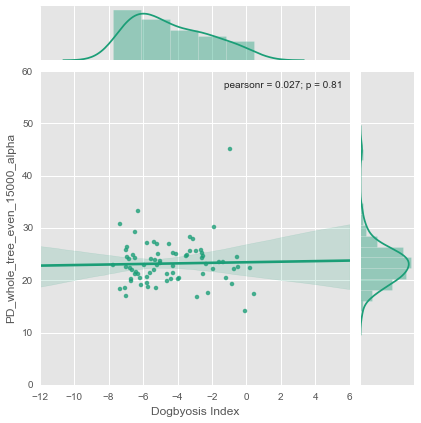

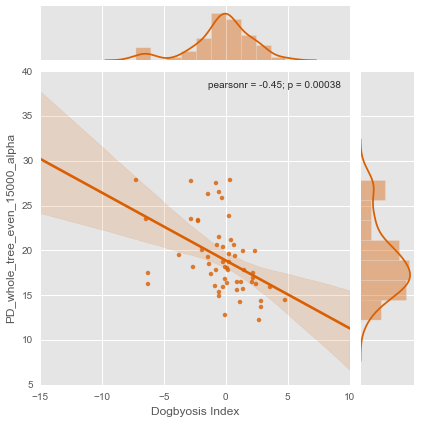

In [5]:
plt.figure()
sns.jointplot('Dogbyosis Index', 'PD_whole_tree_even_15000_alpha',
              mf[mf['disease_stat'] == 'healthy'], kind='reg', color='#1b9e77')
plt.savefig('md-index/new-md-index.healthy.pdf')

plt.figure()
sns.jointplot('Dogbyosis Index', 'PD_whole_tree_even_15000_alpha',
              mf[mf['disease_stat'] != 'healthy'], kind='reg', color='#d95f02')
plt.savefig('md-index/new-md-index.ibd.pdf')

In [9]:
!make_emperor.py -i beta/15000/unweighted_unifrac_pc.txt \
-m  mapping-file.alpha.index.dogbyosis.txt \
-o beta/15000/unweighted-index \
--add_unique_columns

In [10]:
!make_emperor.py -i beta/15000/unweighted_unifrac_pc.txt \
-m mapping-file-full.alpha.L6index.txt \
-o beta/15000/unweighted-index-humans/ \
--add_unique_columns